# IBM DS Professional Certificate - Capstone Project 

# Comparison Of Toronto Neighborhoods To Rent An Apartment In For A Newly Arrived Professional

In [2]:
#Let's load the libraries and packages we will require
#%conda update -n base -c defaults conda
#%conda install -c conda-forge folium=0.5.0 --yes
#%conda install -c conda-forge/label/cf201901 geopy --yes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
%matplotlib inline
import requests

#### Download and Prepare Toronto neighborhoods data from Wikipedia

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df_postalcodes = pd.read_html(requests.get(url).content)[0] # Retrieves the table on the wikipedia page
df_postalcodes.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
df_postalcodes.rename(columns = {'Postcode':'Postal Code'},inplace=True)

In [5]:
#Examine size of the dataset
df_postalcodes.shape

(287, 3)

In [6]:
# Preparing the data by removing 'Not assigned' values
df_postalcodes = df_postalcodes[df_postalcodes['Borough']!='Not assigned']
df_postalcodes.shape

(210, 3)

In [7]:
df_not_assigned_neigh = df_postalcodes[df_postalcodes['Neighbourhood']=='Not assigned']
df_not_assigned_neigh.shape

(0, 3)

##### Postcodes with 'Not assigned' boroughs were removed. The updated dataset does not contain any borough or neighbourhood values which are 'Not assigned'

All neighborhoods associated with a postal code are brought together in one rows with comma separated format

In [8]:
df_postalcodes1 = df_postalcodes.groupby(by=['Postal Code','Borough']).agg(lambda x: ','.join(x))
df_postalcodes1.reset_index(level=['Postal Code','Borough'], inplace=True)

In [9]:
df_postalcodes1.shape

(103, 3)

##### Next we will import the geographical coordinates of each postal code and add them to the dataset

In [10]:
latlong = pd.read_csv('https://cocl.us/Geospatial_data')
latlong.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
latlong.shape

(103, 3)

In [12]:
#From observation of several venues using Python Geopy and Google Maps, the location coordinates of code M5V need to be adjusted a little to be more representative. We will make this correction here.
latlong[latlong['Postal Code'] == 'M5V']

,Postal Code,Latitude,Longitude
68,M5V,43.628947,-79.39442


In [13]:
latlong.iat[68,1] = 43.6360389
latlong.iat[68,2] = -79.3973998

In [14]:
# Joining the Toronto postalcodes dataset with latitude and longitude data
df_combined = pd.merge(df_postalcodes1, latlong, on='Postal Code', how='inner')
df_combined.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [15]:
df_combined.rename(columns={'Neighbourhood':'Neighborhood'},inplace=True)
df_combined.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [16]:
df_combined.shape

(103, 5)

In [17]:
group1 = df_combined.groupby(['Borough'], as_index=False)['Postal Code'].count()
group1

,Borough,Postal Code
0,Central Toronto,9
1,Downtown Toronto,19
2,East Toronto,5
3,East York,5
4,Etobicoke,12
5,Mississauga,1
6,North York,24
7,Scarborough,17
8,West Toronto,6
9,York,5


##### Now we will segment and cluster the Toronto neighborhoods based on location details imported from FourSquare database

#### Let's visualize the selected neighborhoods on the map of Toronto

In [18]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [19]:
# Toronto latitude and longitude values
latitude = 43.65
longitude = -79.35
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_combined['Latitude'], df_combined['Longitude'], df_combined['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [20]:
# @hidden_cell
CLIENT_ID = 'WHU4GOVRKHK3R4HNN1OX5H5Y2PKMV4Y2YJHYO1IQICB12XVO' # your Foursquare ID
CLIENT_SECRET = 'UQTPGGK0OPXX4W0UWYFECEAKQSS004LFUSS0RLQLSTAUTZ5T' # your Foursquare Secret
VERSION = '20200201' # Foursquare API version

In [21]:
#Let's find out the location coordinates of our office location
LIMIT = 5
Cityname = 'Toronto, ON'
worklocation = 'Ubisoft Toronto'
# create URL
url1 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&query={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Cityname,
    worklocation,
    LIMIT)
url1 # display URL


'https://api.foursquare.com/v2/venues/search?&client_id=WHU4GOVRKHK3R4HNN1OX5H5Y2PKMV4Y2YJHYO1IQICB12XVO&client_secret=UQTPGGK0OPXX4W0UWYFECEAKQSS004LFUSS0RLQLSTAUTZ5T&v=20200201&near=Toronto, ON&query=Ubisoft Toronto&limit=5'

In [22]:
results = requests.get(url1).json()
results

{'meta': {'code': 200, 'requestId': '5e6f1a5ddd0f850021791788'},
 'response': {'venues': [{'id': '4bf40b9094af2d7f33193a72',
    'name': 'Ubisoft Toronto',
    'location': {'address': '224 Wallace Ave',
     'lat': 43.66285534470668,
     'lng': -79.44650329003366,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.66285534470668,
       'lng': -79.44650329003366}],
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['224 Wallace Ave', 'Toronto ON', 'Canada']},
    'categories': [{'id': '4bf58dd8d48988d124941735',
      'name': 'Office',
      'pluralName': 'Offices',
      'shortName': 'Office',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1584339922',
    'hasPerk': False},
   {'id': '4acbafc4f964a520fbc420e3',
    'name': 'Toronto Pearson International Airport (YYZ) (Toronto Pearson International Airpo

In [23]:
Office_lat = results ['response'] ['venues'] [0]['location'] ['lat']
Office_lng = results ['response'] ['venues'] [0]['location'] ['lng']

In [24]:
print (Office_lat, Office_lat)

43.66285534470668 43.66285534470668


In [25]:
#Now let's look for apartments/condos within 12 km of office at Ubisoft Toronto
LIMIT = 100
radius = 12000 #in meters
categoryId = '4d954b06a243a5684965b473'
sortByDistance = 1
# create URL
url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}&sortByDistance={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Office_lat,
    Office_lng,
    radius,
    LIMIT,
    categoryId,
    sortByDistance)
url2 # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=WHU4GOVRKHK3R4HNN1OX5H5Y2PKMV4Y2YJHYO1IQICB12XVO&client_secret=UQTPGGK0OPXX4W0UWYFECEAKQSS004LFUSS0RLQLSTAUTZ5T&v=20200201&ll=43.66285534470668,-79.44650329003366&radius=12000&limit=100&categoryId=4d954b06a243a5684965b473&sortByDistance=1'

In [26]:
venues = requests.get(url2).json()["response"]['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.location.address','venue.location.crossStreet','venue.location.lat', 'venue.location.lng', 'venue.location.distance', 'venue.location.postalCode']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,id,name,address,crossStreet,lat,lng,distance,postalCode
0,50e750c1e4b0cacd9c1d39a2,The Crossways,2340-2360 Dundas St W,at Bloor St W,43.657182,-79.452470,793,M6P 4A9
1,554a46e6498e69d0f298ff89,High Park Village,111 Pacific Avenue,NaN,43.656437,-79.464438,1611,M6P 2P2
2,5057d2fde4b07b064b98c7ab,Triller,55 Triller Ave,NaN,43.639942,-79.443712,2560,NaN
3,5273987811d2c4e142f13206,8G,8 Gladstone Avenue,Queen Street West,43.643074,-79.427448,2684,NaN
4,4ae9fb0df964a5202db821e3,Little Italy,NaN,NaN,43.656374,-79.413223,2775,M6J


In [27]:
nearby_venues.shape

(100, 8)

The FourSquare 'explore' query returns 100 results max

In [28]:
nearby_venues.reset_index(drop=True,inplace = True)
nearby_venues

,id,name,address,crossStreet,lat,lng,distance,postalCode
0,50e750c1e4b0cacd9c1d39a2,The Crossways,2340-2360 Dundas St W,at Bloor St W,43.657182,-79.452470,793,M6P 4A9
1,554a46e6498e69d0f298ff89,High Park Village,111 Pacific Avenue,NaN,43.656437,-79.464438,1611,M6P 2P2
2,5057d2fde4b07b064b98c7ab,Triller,55 Triller Ave,NaN,43.639942,-79.443712,2560,NaN
3,5273987811d2c4e142f13206,8G,8 Gladstone Avenue,Queen Street West,43.643074,-79.427448,2684,NaN
4,4ae9fb0df964a5202db821e3,Little Italy,NaN,NaN,43.656374,-79.413223,2775,M6J
...,...,...,...,...,...,...,...,...
95,4d48d1f39544a09366ff21e7,Minto Midtown - Quantum South,2181 Yonge St.,at Eglinton Ave. E,43.705357,-79.397424,6163,NaN
96,4b72603ff964a52034792de3,191 Sherbourne,191 Sherbourne,Shuter,43.656591,-79.370199,6184,M5A 3X1
97,4c0727bccf8c76b059b43b65,330 Adelaide St East,330 Adelaide St East,Sherbourne,43.652112,-79.369101,6347,M5A 4S9
98,4c81602b88e6199c651ab2d4,The Modern Condos,320 Richmond Street East,Sherbourne,43.653783,-79.368659,6350,NaN


In [29]:
nearby_venues.isnull().sum()

id              0
name            0
address         8
crossStreet    41
lat             0
lng             0
distance        0
postalCode     45
dtype: int64

In [30]:
pcodes_set1 = nearby_venues[nearby_venues['postalCode'].isnull()]
nearby_venues.dropna(subset=['postalCode'],axis=0,inplace=True)
print(pcodes_set1.shape, nearby_venues.shape)

(45, 8) (55, 8)


In [31]:
nearby_venues.reset_index(drop=True,inplace = True)
nearby_venues

,id,name,address,crossStreet,lat,lng,distance,postalCode
0,50e750c1e4b0cacd9c1d39a2,The Crossways,2340-2360 Dundas St W,at Bloor St W,43.657182,-79.452470,793,M6P 4A9
1,554a46e6498e69d0f298ff89,High Park Village,111 Pacific Avenue,NaN,43.656437,-79.464438,1611,M6P 2P2
2,4ae9fb0df964a5202db821e3,Little Italy,NaN,NaN,43.656374,-79.413223,2775,M6J
3,4d9d01a0a695721e235b080d,Bridge Condos,38 Joe Shuster Way,King St W & Dufferin St,43.641018,-79.424441,3011,M6K 0A5
4,4afa3d22f964a520761722e3,Battery Park Tower,50 Lynn Williams St,btwn Western Battery and Pirandello,43.639024,-79.415510,3642,M6K 3R9
5,52a2368711d22b97456ae049,Kensington Market Lofts,160 Baldwin St & 21 Nassau St,Spadina Ave,43.655445,-79.400217,3817,M5T 1M2
6,5a5bf7f2cad1b6418ced0028,CampusOne,253 College Street,Spadina,43.657941,-79.399076,3858,M5T 1R5
7,575c87d2498ee77300bceea2,The Brant Park,39 Brant St,Adelaide St W,43.646454,-79.398002,4311,M5V 3G9
8,4e5e511f091a33a643c3ced4,Tridel Rêve,560 Front St. West,btwn Bathurst & Portland,43.641664,-79.400603,4385,M5V 1C1
9,4ae2eb0ef964a520b18f21e3,District Lofts,388 Richmond St W,at Spadina Ave,43.648581,-79.395380,4413,M5V 3P1


In [32]:
nearby_venues.rename(columns={'id':'venueID','postalCode':'Postal Code'},inplace=True)
pcodes_set1.rename(columns={'id':'venueID','postalCode':'Postal Code'},inplace=True)

C:\Users\manan\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [33]:
#Extracting first three letters out of postalCode and ensuring they are in standard captilazied form
nearby_venues['Postal Code'] = nearby_venues['Postal Code'].str[:3]
nearby_venues['Postal Code'] = nearby_venues['Postal Code'].str.upper()

In [34]:
#Now let's add the borough, neighborhood name and neighborhood location coordinates to the sets
df_resi_neigh = pd.merge(nearby_venues, df_combined, on='Postal Code', how='left')

In [35]:
df_resi_neigh.head()

,venueID,name,address,crossStreet,lat,lng,distance,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,50e750c1e4b0cacd9c1d39a2,The Crossways,2340-2360 Dundas St W,at Bloor St W,43.657182,-79.452470,793,M6P,West Toronto,"High Park,The Junction South",43.661608,-79.464763
1,554a46e6498e69d0f298ff89,High Park Village,111 Pacific Avenue,NaN,43.656437,-79.464438,1611,M6P,West Toronto,"High Park,The Junction South",43.661608,-79.464763
2,4ae9fb0df964a5202db821e3,Little Italy,NaN,NaN,43.656374,-79.413223,2775,M6J,West Toronto,"Little Portugal,Trinity",43.647927,-79.419750
3,4d9d01a0a695721e235b080d,Bridge Condos,38 Joe Shuster Way,King St W & Dufferin St,43.641018,-79.424441,3011,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191
4,4afa3d22f964a520761722e3,Battery Park Tower,50 Lynn Williams St,btwn Western Battery and Pirandello,43.639024,-79.415510,3642,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191


In [36]:
df_resi_neigh.rename(columns={'venueID':'PropertyID','name':'PropertyName','lat':'PropertyLat','lng':'PropertyLng','distance':'DistanceFromOffice','Latitude':'Neigh_Latitude','Longitude':'Neigh_Longitude'},inplace=True)

In [37]:
group2 = df_resi_neigh.groupby(['Postal Code'], as_index=False).count()
group2['Postal Code'].count()

16

##### From FourSquare, 16 postal codes and their associated neighborhoods have been identified for 55 apartment/ condo buildings within a 12 km radius of the office location

In [38]:
#Now let's consider the venues for which FourSquare didn't return a postal code. We will try to get the postal codes with OpenStreetMap (OSM) database
pcodes_set1.head()

,venueID,name,address,crossStreet,lat,lng,distance,Postal Code
2,5057d2fde4b07b064b98c7ab,Triller,55 Triller Ave,NaN,43.639942,-79.443712,2560,NaN
3,5273987811d2c4e142f13206,8G,8 Gladstone Avenue,Queen Street West,43.643074,-79.427448,2684,NaN
6,54036a6a498e0e488d9b5e85,DNA 3 Condos,1030 King Street West,Shaw Street,43.641305,-79.416182,3423,NaN
7,4ce67643948f224b1ff2e35d,NXT Condos,103 The Queensway,NaN,43.636120,-79.471030,3572,NaN
8,4c14d65fa1010f47adfc4c18,Vibe / 100 Western Battery,100 western battery road,Lynn williams place,43.639643,-79.415429,3597,NaN


In [39]:
pcodes_set2 = pcodes_set1.copy()

In [40]:
pcodes_set1.reset_index(drop=True,inplace = True)
pcodes_set1

,venueID,name,address,crossStreet,lat,lng,distance,Postal Code
0,5057d2fde4b07b064b98c7ab,Triller,55 Triller Ave,NaN,43.639942,-79.443712,2560,NaN
1,5273987811d2c4e142f13206,8G,8 Gladstone Avenue,Queen Street West,43.643074,-79.427448,2684,NaN
2,54036a6a498e0e488d9b5e85,DNA 3 Condos,1030 King Street West,Shaw Street,43.641305,-79.416182,3423,NaN
3,4ce67643948f224b1ff2e35d,NXT Condos,103 The Queensway,NaN,43.636120,-79.471030,3572,NaN
4,4c14d65fa1010f47adfc4c18,Vibe / 100 Western Battery,100 western battery road,Lynn williams place,43.639643,-79.415429,3597,NaN
5,4b11c473f964a5203e8423e3,Zip / 80 Western Battery,80 Western Battery rd.,Liberty Village,43.639485,-79.414941,3637,NaN
6,5645eab0498ebb7b50ddef60,The Heathview,320 Tweedsmuir Ave,NaN,43.685747,-79.414139,3644,NaN
7,5359b829498ed3e4e50d338a,150 East Liberty Street,NaN,NaN,43.638793,-79.415773,3647,NaN
8,4b0b40cef964a520742f23e3,Liberty Village Town Homes,Western Battery Road,East Liberty / Pirandello,43.639584,-79.412504,3769,NaN
9,5193852f498e4db8be7581a6,75 East Liberty St,75 East Liberty st,Liberty Village,43.638014,-79.414503,3780,NaN


In [41]:
pcodes_set1['name1'] = pcodes_set1['name'].astype(str).replace('[^a-zA-Z0-9 ]', '', regex=True)

C:\Users\manan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
pcodes_set1['address1'] = pcodes_set1['address'].astype(str).replace('[^a-zA-Z0-9 ]', '', regex=True)
pcodes_set1['crossStreet1'] = pcodes_set1['crossStreet'].astype(str).replace('[^a-zA-Z0-9 ]', '', regex=True)
pcodes_set1.drop(['address', 'name', 'crossStreet'], inplace=True, axis=1)
pcodes_set1

C:\Users\manan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\manan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\manan\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

,venueID,lat,lng,distance,Postal Code,name1,address1,crossStreet1
0,5057d2fde4b07b064b98c7ab,43.639942,-79.443712,2560,NaN,Triller,55 Triller Ave,nan
1,5273987811d2c4e142f13206,43.643074,-79.427448,2684,NaN,8G,8 Gladstone Avenue,Queen Street West
2,54036a6a498e0e488d9b5e85,43.641305,-79.416182,3423,NaN,DNA 3 Condos,1030 King Street West,Shaw Street
3,4ce67643948f224b1ff2e35d,43.636120,-79.471030,3572,NaN,NXT Condos,103 The Queensway,nan
4,4c14d65fa1010f47adfc4c18,43.639643,-79.415429,3597,NaN,Vibe 100 Western Battery,100 western battery road,Lynn williams place
5,4b11c473f964a5203e8423e3,43.639485,-79.414941,3637,NaN,Zip 80 Western Battery,80 Western Battery rd,Liberty Village
6,5645eab0498ebb7b50ddef60,43.685747,-79.414139,3644,NaN,The Heathview,320 Tweedsmuir Ave,nan
7,5359b829498ed3e4e50d338a,43.638793,-79.415773,3647,NaN,150 East Liberty Street,nan,nan
8,4b0b40cef964a520742f23e3,43.639584,-79.412504,3769,NaN,Liberty Village Town Homes,Western Battery Road,East Liberty Pirandello
9,5193852f498e4db8be7581a6,43.638014,-79.414503,3780,NaN,75 East Liberty St,75 East Liberty st,Liberty Village


In [43]:
pcodes_set1.reset_index(drop=True,inplace = True)

In [44]:
for i in range (0,len(pcodes_set1)):
    if (len(pcodes_set1.iat[i,5])<=3): ## To eliminate lack of a proper available name for the property
        pcodes_set1.iat[i,5] = pcodes_set1.iat[i,6]
    if ((pcodes_set1.iat[i,6] is None) | (pcodes_set1.iat[i,6] == 'nan')):
        pcodes_set1.iat[i,6] = pcodes_set1.iat[i,7]
    if (pcodes_set1.iat[i,6] == 'nan'):
        pcodes_set1.iat[i,6] = None
    if (pcodes_set1.iat[i,7] == 'nan'):
        pcodes_set1.iat[i,7] = None
        
pcodes_set1

,venueID,lat,lng,distance,Postal Code,name1,address1,crossStreet1
0,5057d2fde4b07b064b98c7ab,43.639942,-79.443712,2560,NaN,Triller,55 Triller Ave,None
1,5273987811d2c4e142f13206,43.643074,-79.427448,2684,NaN,8 Gladstone Avenue,8 Gladstone Avenue,Queen Street West
2,54036a6a498e0e488d9b5e85,43.641305,-79.416182,3423,NaN,DNA 3 Condos,1030 King Street West,Shaw Street
3,4ce67643948f224b1ff2e35d,43.636120,-79.471030,3572,NaN,NXT Condos,103 The Queensway,None
4,4c14d65fa1010f47adfc4c18,43.639643,-79.415429,3597,NaN,Vibe 100 Western Battery,100 western battery road,Lynn williams place
5,4b11c473f964a5203e8423e3,43.639485,-79.414941,3637,NaN,Zip 80 Western Battery,80 Western Battery rd,Liberty Village
6,5645eab0498ebb7b50ddef60,43.685747,-79.414139,3644,NaN,The Heathview,320 Tweedsmuir Ave,None
7,5359b829498ed3e4e50d338a,43.638793,-79.415773,3647,NaN,150 East Liberty Street,None,None
8,4b0b40cef964a520742f23e3,43.639584,-79.412504,3769,NaN,Liberty Village Town Homes,Western Battery Road,East Liberty Pirandello
9,5193852f498e4db8be7581a6,43.638014,-79.414503,3780,NaN,75 East Liberty St,75 East Liberty st,Liberty Village


In [45]:
pcodes_set1['address_cross_street'] = pcodes_set1.address1 + ', ' + pcodes_set1.crossStreet1

C:\Users\manan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
pcodes_set1

,venueID,lat,lng,distance,Postal Code,name1,address1,crossStreet1,address_cross_street
0,5057d2fde4b07b064b98c7ab,43.639942,-79.443712,2560,NaN,Triller,55 Triller Ave,None,NaN
1,5273987811d2c4e142f13206,43.643074,-79.427448,2684,NaN,8 Gladstone Avenue,8 Gladstone Avenue,Queen Street West,"8 Gladstone Avenue, Queen Street West"
2,54036a6a498e0e488d9b5e85,43.641305,-79.416182,3423,NaN,DNA 3 Condos,1030 King Street West,Shaw Street,"1030 King Street West, Shaw Street"
3,4ce67643948f224b1ff2e35d,43.636120,-79.471030,3572,NaN,NXT Condos,103 The Queensway,None,NaN
4,4c14d65fa1010f47adfc4c18,43.639643,-79.415429,3597,NaN,Vibe 100 Western Battery,100 western battery road,Lynn williams place,"100 western battery road, Lynn williams place"
5,4b11c473f964a5203e8423e3,43.639485,-79.414941,3637,NaN,Zip 80 Western Battery,80 Western Battery rd,Liberty Village,"80 Western Battery rd, Liberty Village"
6,5645eab0498ebb7b50ddef60,43.685747,-79.414139,3644,NaN,The Heathview,320 Tweedsmuir Ave,None,NaN
7,5359b829498ed3e4e50d338a,43.638793,-79.415773,3647,NaN,150 East Liberty Street,None,None,NaN
8,4b0b40cef964a520742f23e3,43.639584,-79.412504,3769,NaN,Liberty Village Town Homes,Western Battery Road,East Liberty Pirandello,"Western Battery Road, East Liberty Pirandello"
9,5193852f498e4db8be7581a6,43.638014,-79.414503,3780,NaN,75 East Liberty St,75 East Liberty st,Liberty Village,"75 East Liberty st, Liberty Village"


In [47]:
#Initializing
geolocator = Nominatim(user_agent="Toronto explorer1", country_bias='CA', timeout=5)

In [48]:
# The first pass consists of looking for postal codes for residential buildings by their name
pcodes_firstpass = []
for i in range (0,len(pcodes_set1)):
    nameforpcode = pcodes_set1.iloc[i,5]
    namePCresults = geolocator.geocode((nameforpcode + ' Toronto'),addressdetails=True)
    try:
        pcodes_firstpass.append(
            namePCresults.raw['address']['postcode'])
    except:
        pcodes_firstpass.append('Not found')
    print(nameforpcode,pcodes_firstpass[i])


Triller M6R 1A9
8 Gladstone Avenue M6J 1J6
DNA 3 Condos Not found
NXT Condos Not found
Vibe  100 Western Battery Not found
Zip  80 Western Battery Not found
The Heathview M2K 1G3
150 East Liberty Street M6K 3P8
Liberty Village Town Homes Not found
75 East Liberty St M6K 3P8
156 Portland M8V 1M6
The Summit Complex Not found
Thompson Residences Not found
Yorkville 155 M5R 1C1
Thompson Hotel Residences Not found
Atlantis Aquarius M5V 4A1
Neptune M6A 2L3
215 Fort York Blvd M5V 4A1
U Condominiums Not found
151 Dan Leckie Way M5V 4A7
44 St Joseph Not found
Panorama Cityplace Condos Not found
The Bay Club M5S 1Z6
25 Telegram Mews M5V 3Z9
Burano Condos Not found
Gym at Neo Not found
15 Fort York M5V 1B3
21 Nelson Street M1J 2M7
11 Brunel Court M5V 3Y7
8 Wellesley St E M4Y 1E7
Chaz Yorkville M4Y 2T0
Toronto Holiday Inn M6K 1X9
Westlake Condos Not found
Charles St M4Y 2T0
Couture Condominium Not found
California Condos Not found
15 Maitland Place M4Y 2G8
40 Homewood M4X 1K2
Success Tower M5E
18 

In [49]:
pcodes_set1['Postal Code1'] = np.array(pcodes_firstpass)
pcodes_set1.groupby('Postal Code1')['Postal Code1'].count()

C:\Users\manan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Postal Code1
M1J 2M7       1
M2K 1G3       1
M2P 2Y3       1
M4P 1A9       1
M4X 1K2       1
M4Y 1E7       1
M4Y 2G8       1
M4Y 2T0       2
M5E           3
M5J 2V3       1
M5R 1C1       1
M5S 1Z6       1
M5V 1B3       1
M5V 3Y7       1
M5V 3Z9       1
M5V 4A1       2
M5V 4A7       1
M6A 2L3       1
M6J 1J6       1
M6K 1X9       1
M6K 3P8       2
M6R 1A9       1
M8V 1M6       1
Not found    17
Name: Postal Code1, dtype: int64

In [50]:
# We can determine that the actual locations corresponding to postal codes M1J, M2K and M2P are not within 12km from office location. The correct pincodes to be assigned to corresponding properties are: 
#Madison condos M4S, Heathview M5P, 21 Nelson Street M5V
pcodes_set1.iat[44,9] = 'M4S'
pcodes_set1.iat[27,9] = 'M5V'
pcodes_set1.iat[6,9] = 'M5P'

In [51]:
# In the second pass we will try to find postal code associated with street address
pcodes_secondpass = []
for i in range (0,len(pcodes_set1)):
    nameforpcode = pcodes_set1.iloc[i,6]
    if (pcodes_set1.iloc[i,9] == 'Not found'):
        try:
            namePCresults = geolocator.geocode((nameforpcode + ' Toronto'),addressdetails=True)
            pcodes_secondpass.append(
            namePCresults.raw['address']['postcode'])
        except:
            pcodes_secondpass.append('Not found')
    else:
        pcodes_secondpass.append(pcodes_set1.iloc[i,9]) #If two different postal codes are found for name and address respectively, we keep the one fetched by name
    print(nameforpcode,pcodes_secondpass[i])

55 Triller Ave M6R 1A9
8 Gladstone Avenue M6J 1J6
1030 King Street West M6K 3R9
103 The Queensway Not found
100 western battery road M6K 3R9
80 Western Battery rd M6K 3R9
320 Tweedsmuir Ave M5P
None M6K 3P8
Western Battery Road M6K 3R9
75 East Liberty st M6K 3P8
156 Portland M8V 1M6
701 King St M6L 1N4
629 King St M6L 1N4
Yorkville Avenue 155 M5R 1C1
55 Stewart Street M5V 2V5
231 Fort York Blvd M5V 4A1
215 Fort York M6A 2L3
None M5V 4A1
Bay St M4W 0A4
151 Dan Leckie Way M5V 4A7
44 St Joseph Street M5S 3A5
38 Dan Leckie Way M5V 4A7
925 Bay St M5S 1Z6
None M5V 3Z9
832 Bay St M5S 1Z6
15 Fort York Boulevard M5V 3Y7
None M5V 1B3
21 Nelson St M5V
11 Brunel Court M5V 3Y7
8 Wellesley St E M4Y 1E7
45 Charles St East M4Y 2T0
None M6K 1X9
None Not found
Charles St M4Y 2T0
Ted Rogers Way M4Y 2J4
165 Legion Road North M8Y 1G4
15 Maitland Place M4Y 2G8
None M4X 1K2
16 Harbour Street M5E
18 Yonge St M5E
18 Harbour Street M5E
10 Yonge St M5J 2V3
2181 Yonge St M4P 1A9
320 Richmond Street East M5C 1N8
m

In [52]:
pcodes_set1['Postal Code2'] = np.array(pcodes_secondpass)
pcodes_set1.groupby('Postal Code2')['Postal Code2'].count()

C:\Users\manan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Postal Code2
M4P 1A9      1
M4S          1
M4W 0A4      1
M4X 1K2      1
M4Y 1E7      1
M4Y 2G8      1
M4Y 2J4      1
M4Y 2T0      2
M5C 1N8      1
M5E          3
M5J 2V3      1
M5P          1
M5R 1C1      1
M5S 1Z6      2
M5S 3A5      1
M5V          1
M5V 1B3      1
M5V 2V5      1
M5V 3Y7      2
M5V 3Z9      1
M5V 4A1      2
M5V 4A7      2
M6A 2L3      1
M6J 1J6      1
M6K 1X9      1
M6K 3P8      2
M6K 3R9      4
M6L 1N4      2
M6R 1A9      1
M8V 1M6      1
M8Y 1G4      1
Not found    2
Name: Postal Code2, dtype: int64

In [53]:
pcodes_set1

,venueID,lat,lng,distance,Postal Code,name1,address1,crossStreet1,address_cross_street,Postal Code1,Postal Code2
0,5057d2fde4b07b064b98c7ab,43.639942,-79.443712,2560,NaN,Triller,55 Triller Ave,None,NaN,M6R 1A9,M6R 1A9
1,5273987811d2c4e142f13206,43.643074,-79.427448,2684,NaN,8 Gladstone Avenue,8 Gladstone Avenue,Queen Street West,"8 Gladstone Avenue, Queen Street West",M6J 1J6,M6J 1J6
2,54036a6a498e0e488d9b5e85,43.641305,-79.416182,3423,NaN,DNA 3 Condos,1030 King Street West,Shaw Street,"1030 King Street West, Shaw Street",Not found,M6K 3R9
3,4ce67643948f224b1ff2e35d,43.636120,-79.471030,3572,NaN,NXT Condos,103 The Queensway,None,NaN,Not found,Not found
4,4c14d65fa1010f47adfc4c18,43.639643,-79.415429,3597,NaN,Vibe 100 Western Battery,100 western battery road,Lynn williams place,"100 western battery road, Lynn williams place",Not found,M6K 3R9
5,4b11c473f964a5203e8423e3,43.639485,-79.414941,3637,NaN,Zip 80 Western Battery,80 Western Battery rd,Liberty Village,"80 Western Battery rd, Liberty Village",Not found,M6K 3R9
6,5645eab0498ebb7b50ddef60,43.685747,-79.414139,3644,NaN,The Heathview,320 Tweedsmuir Ave,None,NaN,M5P,M5P
7,5359b829498ed3e4e50d338a,43.638793,-79.415773,3647,NaN,150 East Liberty Street,None,None,NaN,M6K 3P8,M6K 3P8
8,4b0b40cef964a520742f23e3,43.639584,-79.412504,3769,NaN,Liberty Village Town Homes,Western Battery Road,East Liberty Pirandello,"Western Battery Road, East Liberty Pirandello",Not found,M6K 3R9
9,5193852f498e4db8be7581a6,43.638014,-79.414503,3780,NaN,75 East Liberty St,75 East Liberty st,Liberty Village,"75 East Liberty st, Liberty Village",M6K 3P8,M6K 3P8


In [54]:
# In the third pass we will try to find postal code associated with a combination of street address and cross street
pcodes_thirdpass = []
for i in range (0,len(pcodes_set1)):
    nameforpcode = pcodes_set1.iloc[i,8]
    if (pcodes_set1.iloc[i,10] == 'Not found'):
        try:
            namePCresults = geolocator.geocode((nameforpcode + ' Toronto'),addressdetails=True)
            pcodes_thirdpass.append(
            namePCresults.raw['address']['postcode'])
        except:
            pcodes_thirdpass.append('Not found')
    else:
        pcodes_thirdpass.append(pcodes_set1.iloc[i,10]) #If two different postal codes are found for address and cross-street respectively, we keep the one fetched by address
    print(nameforpcode,pcodes_thirdpass[i])

nan M6R 1A9
8 Gladstone Avenue, Queen Street West M6J 1J6
1030 King Street West, Shaw Street M6K 3R9
nan Not found
100 western battery road, Lynn williams place M6K 3R9
80 Western Battery rd, Liberty Village M6K 3R9
nan M5P
nan M6K 3P8
Western Battery Road, East Liberty  Pirandello M6K 3R9
75 East Liberty st, Liberty Village M6K 3P8
156 Portland, Queen M8V 1M6
701 King St, Bathurst M6L 1N4
nan M6L 1N4
nan M5R 1C1
nan M5V 2V5
nan M5V 4A1
nan M6A 2L3
nan M5V 4A1
Bay St, St Joseph St M4W 0A4
nan M5V 4A7
44 St Joseph Street, Bay Street M5S 3A5
38 Dan Leckie Way, at Lake Shore Blvd W M5V 4A7
925 Bay St, at Wellesley St W M5S 1Z6
nan M5V 3Z9
832 Bay St, Grenville St M5S 1Z6
nan M5V 3Y7
nan M5V 1B3
nan M5V
nan M5V 3Y7
8 Wellesley St E, Yonge  Wellesley M4Y 1E7
nan M4Y 2T0
nan M6K 1X9
nan Not found
Charles St, Jarvis St M4Y 2T0
Ted Rogers Way, Mount Pleasant M4Y 2J4
nan M8Y 1G4
nan M4Y 2G8
nan M4X 1K2
nan M5E
18 Yonge St, at Harbour St M5E
nan M5E
10 Yonge St, at Queens Quay M5J 2V3
2181 Yonge

In [55]:
pcodes_set1['Postal Code3'] = np.array(pcodes_thirdpass)
pcodes_set1.groupby('Postal Code3')['Postal Code3'].count()

C:\Users\manan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Postal Code3
M4P 1A9      1
M4S          1
M4W 0A4      1
M4X 1K2      1
M4Y 1E7      1
M4Y 2G8      1
M4Y 2J4      1
M4Y 2T0      2
M5C 1N8      1
M5E          3
M5J 2V3      1
M5P          1
M5R 1C1      1
M5S 1Z6      2
M5S 3A5      1
M5V          1
M5V 1B3      1
M5V 2V5      1
M5V 3Y7      2
M5V 3Z9      1
M5V 4A1      2
M5V 4A7      2
M6A 2L3      1
M6J 1J6      1
M6K 1X9      1
M6K 3P8      2
M6K 3R9      4
M6L 1N4      2
M6R 1A9      1
M8V 1M6      1
M8Y 1G4      1
Not found    2
Name: Postal Code3, dtype: int64

In [56]:
pcodes_set1

,venueID,lat,lng,distance,Postal Code,name1,address1,crossStreet1,address_cross_street,Postal Code1,Postal Code2,Postal Code3
0,5057d2fde4b07b064b98c7ab,43.639942,-79.443712,2560,NaN,Triller,55 Triller Ave,None,NaN,M6R 1A9,M6R 1A9,M6R 1A9
1,5273987811d2c4e142f13206,43.643074,-79.427448,2684,NaN,8 Gladstone Avenue,8 Gladstone Avenue,Queen Street West,"8 Gladstone Avenue, Queen Street West",M6J 1J6,M6J 1J6,M6J 1J6
2,54036a6a498e0e488d9b5e85,43.641305,-79.416182,3423,NaN,DNA 3 Condos,1030 King Street West,Shaw Street,"1030 King Street West, Shaw Street",Not found,M6K 3R9,M6K 3R9
3,4ce67643948f224b1ff2e35d,43.636120,-79.471030,3572,NaN,NXT Condos,103 The Queensway,None,NaN,Not found,Not found,Not found
4,4c14d65fa1010f47adfc4c18,43.639643,-79.415429,3597,NaN,Vibe 100 Western Battery,100 western battery road,Lynn williams place,"100 western battery road, Lynn williams place",Not found,M6K 3R9,M6K 3R9
5,4b11c473f964a5203e8423e3,43.639485,-79.414941,3637,NaN,Zip 80 Western Battery,80 Western Battery rd,Liberty Village,"80 Western Battery rd, Liberty Village",Not found,M6K 3R9,M6K 3R9
6,5645eab0498ebb7b50ddef60,43.685747,-79.414139,3644,NaN,The Heathview,320 Tweedsmuir Ave,None,NaN,M5P,M5P,M5P
7,5359b829498ed3e4e50d338a,43.638793,-79.415773,3647,NaN,150 East Liberty Street,None,None,NaN,M6K 3P8,M6K 3P8,M6K 3P8
8,4b0b40cef964a520742f23e3,43.639584,-79.412504,3769,NaN,Liberty Village Town Homes,Western Battery Road,East Liberty Pirandello,"Western Battery Road, East Liberty Pirandello",Not found,M6K 3R9,M6K 3R9
9,5193852f498e4db8be7581a6,43.638014,-79.414503,3780,NaN,75 East Liberty St,75 East Liberty st,Liberty Village,"75 East Liberty st, Liberty Village",M6K 3P8,M6K 3P8,M6K 3P8


In [57]:
for i in range (0,len(pcodes_set1)):
    if (pcodes_set1.iloc[i,9] == pcodes_set1.iloc[i,10]):
        pcodes_set1.iloc[i,4] = pcodes_set1.iloc[i,9]
    else:
        pcodes_set1.iloc[i,4] = pcodes_set1.iloc[i,10]
pcodes_set1

C:\Users\manan\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,venueID,lat,lng,distance,Postal Code,name1,address1,crossStreet1,address_cross_street,Postal Code1,Postal Code2,Postal Code3
0,5057d2fde4b07b064b98c7ab,43.639942,-79.443712,2560,M6R 1A9,Triller,55 Triller Ave,None,NaN,M6R 1A9,M6R 1A9,M6R 1A9
1,5273987811d2c4e142f13206,43.643074,-79.427448,2684,M6J 1J6,8 Gladstone Avenue,8 Gladstone Avenue,Queen Street West,"8 Gladstone Avenue, Queen Street West",M6J 1J6,M6J 1J6,M6J 1J6
2,54036a6a498e0e488d9b5e85,43.641305,-79.416182,3423,M6K 3R9,DNA 3 Condos,1030 King Street West,Shaw Street,"1030 King Street West, Shaw Street",Not found,M6K 3R9,M6K 3R9
3,4ce67643948f224b1ff2e35d,43.636120,-79.471030,3572,Not found,NXT Condos,103 The Queensway,None,NaN,Not found,Not found,Not found
4,4c14d65fa1010f47adfc4c18,43.639643,-79.415429,3597,M6K 3R9,Vibe 100 Western Battery,100 western battery road,Lynn williams place,"100 western battery road, Lynn williams place",Not found,M6K 3R9,M6K 3R9
5,4b11c473f964a5203e8423e3,43.639485,-79.414941,3637,M6K 3R9,Zip 80 Western Battery,80 Western Battery rd,Liberty Village,"80 Western Battery rd, Liberty Village",Not found,M6K 3R9,M6K 3R9
6,5645eab0498ebb7b50ddef60,43.685747,-79.414139,3644,M5P,The Heathview,320 Tweedsmuir Ave,None,NaN,M5P,M5P,M5P
7,5359b829498ed3e4e50d338a,43.638793,-79.415773,3647,M6K 3P8,150 East Liberty Street,None,None,NaN,M6K 3P8,M6K 3P8,M6K 3P8
8,4b0b40cef964a520742f23e3,43.639584,-79.412504,3769,M6K 3R9,Liberty Village Town Homes,Western Battery Road,East Liberty Pirandello,"Western Battery Road, East Liberty Pirandello",Not found,M6K 3R9,M6K 3R9
9,5193852f498e4db8be7581a6,43.638014,-79.414503,3780,M6K 3P8,75 East Liberty St,75 East Liberty st,Liberty Village,"75 East Liberty st, Liberty Village",M6K 3P8,M6K 3P8,M6K 3P8


In [58]:
pcodes_set1.groupby('Postal Code')['Postal Code'].count()

Postal Code
M4P 1A9      1
M4S          1
M4W 0A4      1
M4X 1K2      1
M4Y 1E7      1
M4Y 2G8      1
M4Y 2J4      1
M4Y 2T0      2
M5C 1N8      1
M5E          3
M5J 2V3      1
M5P          1
M5R 1C1      1
M5S 1Z6      2
M5S 3A5      1
M5V          1
M5V 1B3      1
M5V 2V5      1
M5V 3Y7      2
M5V 3Z9      1
M5V 4A1      2
M5V 4A7      2
M6A 2L3      1
M6J 1J6      1
M6K 1X9      1
M6K 3P8      2
M6K 3R9      4
M6L 1N4      2
M6R 1A9      1
M8V 1M6      1
M8Y 1G4      1
Not found    2
Name: Postal Code, dtype: int64

In [59]:
pcodes_set1 = pcodes_set1[pcodes_set1['Postal Code']!='Not found']

In [60]:
pcodes_set1.drop(["Postal Code1","Postal Code2","Postal Code3",'address_cross_street'],axis=1,inplace=True)

In [61]:
pcodes_set1['Postal Code'] = pcodes_set1['Postal Code'].str[:3]

C:\Users\manan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
pcodes_set1.reset_index(drop=True,inplace = True)

In [63]:
pcodes_set1.shape

(43, 8)

In [64]:
pcodes_set1.head()

,venueID,lat,lng,distance,Postal Code,name1,address1,crossStreet1
0,5057d2fde4b07b064b98c7ab,43.639942,-79.443712,2560,M6R,Triller,55 Triller Ave,None
1,5273987811d2c4e142f13206,43.643074,-79.427448,2684,M6J,8 Gladstone Avenue,8 Gladstone Avenue,Queen Street West
2,54036a6a498e0e488d9b5e85,43.641305,-79.416182,3423,M6K,DNA 3 Condos,1030 King Street West,Shaw Street
3,4c14d65fa1010f47adfc4c18,43.639643,-79.415429,3597,M6K,Vibe 100 Western Battery,100 western battery road,Lynn williams place
4,4b11c473f964a5203e8423e3,43.639485,-79.414941,3637,M6K,Zip 80 Western Battery,80 Western Battery rd,Liberty Village


In [65]:
df_resi_neigh.head()

,PropertyID,PropertyName,address,crossStreet,PropertyLat,PropertyLng,DistanceFromOffice,Postal Code,Borough,Neighborhood,Neigh_Latitude,Neigh_Longitude
0,50e750c1e4b0cacd9c1d39a2,The Crossways,2340-2360 Dundas St W,at Bloor St W,43.657182,-79.452470,793,M6P,West Toronto,"High Park,The Junction South",43.661608,-79.464763
1,554a46e6498e69d0f298ff89,High Park Village,111 Pacific Avenue,NaN,43.656437,-79.464438,1611,M6P,West Toronto,"High Park,The Junction South",43.661608,-79.464763
2,4ae9fb0df964a5202db821e3,Little Italy,NaN,NaN,43.656374,-79.413223,2775,M6J,West Toronto,"Little Portugal,Trinity",43.647927,-79.419750
3,4d9d01a0a695721e235b080d,Bridge Condos,38 Joe Shuster Way,King St W & Dufferin St,43.641018,-79.424441,3011,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191
4,4afa3d22f964a520761722e3,Battery Park Tower,50 Lynn Williams St,btwn Western Battery and Pirandello,43.639024,-79.415510,3642,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191


In [66]:
#Now let's add the borough, neighborhood name and neighborhood location coordinates to the sets
pcodes_set1 = pd.merge(pcodes_set1, df_combined, on='Postal Code', how='left')
pcodes_set1.head()

,venueID,lat,lng,distance,Postal Code,name1,address1,crossStreet1,Borough,Neighborhood,Latitude,Longitude
0,5057d2fde4b07b064b98c7ab,43.639942,-79.443712,2560,M6R,Triller,55 Triller Ave,None,West Toronto,"Parkdale,Roncesvalles",43.648960,-79.456325
1,5273987811d2c4e142f13206,43.643074,-79.427448,2684,M6J,8 Gladstone Avenue,8 Gladstone Avenue,Queen Street West,West Toronto,"Little Portugal,Trinity",43.647927,-79.419750
2,54036a6a498e0e488d9b5e85,43.641305,-79.416182,3423,M6K,DNA 3 Condos,1030 King Street West,Shaw Street,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191
3,4c14d65fa1010f47adfc4c18,43.639643,-79.415429,3597,M6K,Vibe 100 Western Battery,100 western battery road,Lynn williams place,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191
4,4b11c473f964a5203e8423e3,43.639485,-79.414941,3637,M6K,Zip 80 Western Battery,80 Western Battery rd,Liberty Village,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191


In [67]:
pcodes_set1.rename(columns={'venueID':'PropertyID','name1':'PropertyName','lat':'PropertyLat','lng':'PropertyLng','distance':'DistanceFromOffice','Latitude':'Neigh_Latitude','Longitude':'Neigh_Longitude','address1':'address','crossStreet1':'crossStreet'},inplace=True)

In [68]:
pcodes_set1 = pcodes_set1[['PropertyID', 'PropertyName','address','crossStreet','PropertyLat','PropertyLng','DistanceFromOffice','Postal Code','Borough', 'Neighborhood','Neigh_Latitude','Neigh_Longitude']]

In [69]:
pcodes_set1.head()

,PropertyID,PropertyName,address,crossStreet,PropertyLat,PropertyLng,DistanceFromOffice,Postal Code,Borough,Neighborhood,Neigh_Latitude,Neigh_Longitude
0,5057d2fde4b07b064b98c7ab,Triller,55 Triller Ave,None,43.639942,-79.443712,2560,M6R,West Toronto,"Parkdale,Roncesvalles",43.648960,-79.456325
1,5273987811d2c4e142f13206,8 Gladstone Avenue,8 Gladstone Avenue,Queen Street West,43.643074,-79.427448,2684,M6J,West Toronto,"Little Portugal,Trinity",43.647927,-79.419750
2,54036a6a498e0e488d9b5e85,DNA 3 Condos,1030 King Street West,Shaw Street,43.641305,-79.416182,3423,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191
3,4c14d65fa1010f47adfc4c18,Vibe 100 Western Battery,100 western battery road,Lynn williams place,43.639643,-79.415429,3597,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191
4,4b11c473f964a5203e8423e3,Zip 80 Western Battery,80 Western Battery rd,Liberty Village,43.639485,-79.414941,3637,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191


In [70]:
#Combined dataset
df_resi_neigh.reset_index(drop=True,inplace = True)
pcodes_set1.reset_index(drop=True,inplace = True)
df_properties_with_PC = df_resi_neigh.append(pcodes_set1,ignore_index=True)
df_properties_with_PC.groupby('Postal Code')['Postal Code'].count()

Postal Code
M4P     1
M4S     2
M4V     1
M4W     3
M4X     1
M4Y    13
M5A     2
M5B     2
M5C     1
M5E     6
M5G     2
M5H     4
M5J     5
M5P     1
M5R     1
M5S     4
M5T     2
M5V    28
M6A     1
M6J     2
M6K     9
M6L     2
M6P     2
M6R     1
M8V     1
M8Y     1
Name: Postal Code, dtype: int64

In [71]:
#### This is the consolidated dataset of properties within 15km of the office location, with their associated postal codes
df_properties_with_PC.shape

(98, 12)

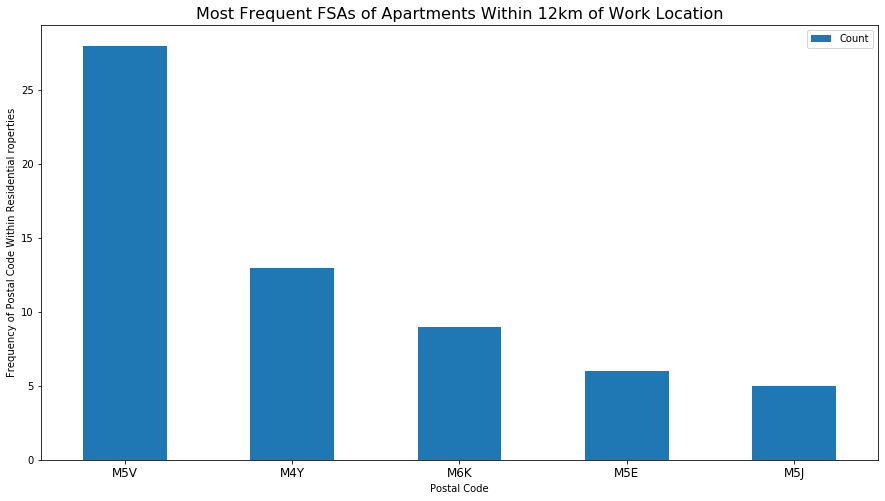

In [72]:
grouped_prop = df_properties_with_PC.groupby('Postal Code')['Postal Code'].count()
grouped_prop1 = grouped_prop.to_frame(name = 'Count').reset_index()
grouped_prop1.sort_values(by=['Count'], inplace=True, ascending = 0)
grouped_prop1.reset_index(drop=True,inplace = True)
grouped_prop1 = grouped_prop1.iloc[0:5,]
grouped_prop1.plot(kind='bar', figsize=(15, 8),x='Postal Code', y='Count', rot=0)

#plt.xlabel('Postal Code') # add to x-label to the plot
plt.ylabel('Frequency of Postal Code Within Residential roperties') # add y-label to the plot
plt.title('Most Frequent FSAs of Apartments Within 12km of Work Location',fontsize = 16) # add title to the plot
plt.xticks(fontsize = 12)

plt.show()

In [73]:
grouped_prop1

,Postal Code,Count
0,M5V,28
1,M4Y,13
2,M6K,9
3,M5E,6
4,M5J,5


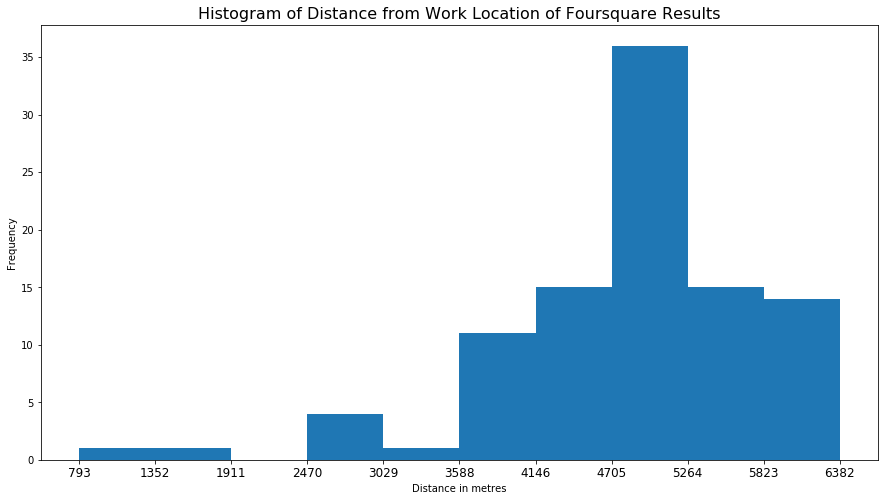

In [74]:
#grouped_prop = df_properties_with_PC.groupby('Postal Code')['DistanceFromOffice']
#grouped_prop1 = grouped_prop.to_frame(name = 'DistanceFromOffice').reset_index()
#grouped_prop1.sort_values(by=['DistanceFromOffice'], inplace=True, ascending = 0)
#grouped_prop1.reset_index(drop=True,inplace = True)
#grouped_prop1 = grouped_prop1.iloc[0:5,]
count, bin_edges = np.histogram(df_properties_with_PC['DistanceFromOffice'])
df_properties_with_PC['DistanceFromOffice'].plot(kind='hist', figsize=(15, 8), xticks=bin_edges)

plt.xlabel('Distance in metres') # add to x-label to the plot
plt.ylabel('Frequency') # add y-label to the plot
plt.title('Histogram of Distance from Work Location of Foursquare Results',fontsize = 16) # add title to the plot
plt.xticks(fontsize = 12)

plt.show()

In [75]:
####################################################################################################################################################################################################
# Now let's get the average prices of a 2 bedroom apartment in Toronto neighborhoods.
url4 = 'https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/TableMatchingCriteria?GeographyType=MetropolitanMajorArea&GeographyId=2270&CategoryLevel1=Primary%20Rental%20Market&CategoryLevel2=Average%20Rent%20%28%24%29&ColumnField=2&RowField=24'
df_rental_prices = pd.read_html(requests.get(url4).content,index_col=None)[0] # Retrieves the table on the wikipedia page
df_rental_prices.head()

,Unnamed: 0,Bachelor,Bachelor.1,1 Bedroom,1 Bedroom.1,2 Bedroom,2 Bedroom.1,3 Bedroom +,3 Bedroom +.1,Total,Total.1
0,Agincourt/Malvern,**,NaN,1234,a,1397,a,1414,c,1352,a
1,Ajax/Pickering,**,NaN,982,a,1237,a,1489,a,1318,a
2,Alderwood,**,NaN,1193,b,1357,c,**,NaN,1320,c
3,Aurora,**,NaN,1171,a,1371,b,**,NaN,1338,b
4,Banbury-Don Mills/York Mills,836,d,1266,b,1432,b,1763,b,1382,b


In [76]:
df_rental_prices.drop(['Bachelor', 'Bachelor.1', '1 Bedroom', '1 Bedroom.1','2 Bedroom.1','3 Bedroom +','3 Bedroom +.1','Total','Total.1'], axis=1, inplace=True)
df_rental_prices.rename(columns={'Unnamed: 0':'Neighborhood','2 Bedroom':'Average_Rent'},inplace=True)
df_rental_prices.tail()

,Neighborhood,Average_Rent
130,Wychwood,**
131,Yonge-Eglinton,2035
132,Yonge-St. Clair,2058
133,Yorkdale-Glen Park,1426
134,Toronto,1563


In [77]:
df_rental_prices = df_rental_prices[df_rental_prices['Average_Rent']!='**']
df_rental_prices.reset_index(drop=True,inplace = True)
df_rental_prices = df_rental_prices[df_rental_prices.Neighborhood != 'Toronto'] #Last value in HTML-scraped table is the average of all Toronto neighborhoods. It is not an independent row in the table
df_rental_prices.shape

(125, 2)

In [78]:
#Let's find out the postal code of each of the neighborhoods in the rental prices dataframe.
df_rental_prices['Neigh_1'] = df_rental_prices['Neighborhood'].str.split(r"\/|-", expand=True)[0]
df_rental_prices['Neigh_2'] = df_rental_prices['Neighborhood'].str.split(r"\/|-", expand=True)[1]
df_rental_prices['Neigh_3'] = df_rental_prices['Neighborhood'].str.split(r"\/|-", expand=True)[2]
df_rental_prices['Neigh_4'] = df_rental_prices['Neighborhood'].str.split(r"\/|-", expand=True)[3]

#df_rental_prices['Neigh_1'] = df_rental_prices['Neigh_1'].str.partition('-')[0]
#df_rental_prices['Neigh_2'] = df_rental_prices['Neigh_2'].str.rpartition('-')[2]
df_rental_prices['Neigh_1'] = df_rental_prices['Neigh_1'].astype(str).replace('[^a-zA-Z0-9 ]', ' ', regex=True)
df_rental_prices['Neigh_2'] = df_rental_prices['Neigh_2'].astype(str).replace('[^a-zA-Z0-9 ]', ' ', regex=True)
df_rental_prices['Neigh_3'] = df_rental_prices['Neigh_3'].astype(str).replace('[^a-zA-Z0-9 ]', ' ', regex=True)
df_rental_prices['Neigh_4'] = df_rental_prices['Neigh_4'].astype(str).replace('[^a-zA-Z0-9 ]', ' ', regex=True)
df_rental_prices.head()

#.str.split(r"\+|=", expand=True)

,Neighborhood,Average_Rent,Neigh_1,Neigh_2,Neigh_3,Neigh_4
0,Agincourt/Malvern,1397,Agincourt,Malvern,None,None
1,Ajax/Pickering,1237,Ajax,Pickering,None,None
2,Alderwood,1357,Alderwood,None,None,None
3,Aurora,1371,Aurora,None,None,None
4,Banbury-Don Mills/York Mills,1432,Banbury,Don Mills,York Mills,None


In [79]:
df_rental_prices.tail()

,Neighborhood,Average_Rent,Neigh_1,Neigh_2,Neigh_3,Neigh_4
120,Woburn,1375,Woburn,None,None,None
121,Woodbine Corridor/Greenwood-Coxwell,1427,Woodbine Corridor,Greenwood,Coxwell,None
122,Yonge-Eglinton,2035,Yonge,Eglinton,None,None
123,Yonge-St. Clair,2058,Yonge,St Clair,None,None
124,Yorkdale-Glen Park,1426,Yorkdale,Glen Park,None,None


In [80]:
# We will try to fetch the postal codes for the neighborhoods with averagre rents using the OpenStreetMap (OSM) API
df_rental_prices_geocoder = df_rental_prices.copy()
df_rental_prices_geocoder.reset_index(drop=True,inplace = True)

In [81]:
rental_pcodes_firstpass = []
for i in range (0,len(df_rental_prices_geocoder)):
    nameforpcode = df_rental_prices_geocoder.iloc[i,2]
    try:
        namePCresults = geolocator.geocode((nameforpcode + ' Toronto') , addressdetails=True)
        rental_pcodes_firstpass.append(
        namePCresults.raw['address']['postcode'])
    except:
        rental_pcodes_firstpass.append('Not found')
    print(nameforpcode,rental_pcodes_firstpass[i])

Agincourt M1S 1T3
Ajax L1S 3G4
Alderwood M8W 3T7
Aurora M6K 1X9
Banbury Not found
Bathurst Manor Not found
Bay Street Corridor M5S 2S3
Bayview Village M2K 1C3
Bedford Park M5M 3E2
Beechborough M6M 3X7
Bendale M1P 2S7
Birchcliffe Not found
Black Creek M6L 3C9
Bradford L3Z 2Z7
Brampton  East  L6R 1A2
Brampton  West  L6R 1A2
Briar Hill Not found
Broadview North M4K 2S1
Bronte Not found
Brookhaven M6M 4N8
Cabbagetown M5A 3A3
Caledonia M6E 4Y2
Casa Loma M5R 1X9
Churchill Meadows Not found
Church M6K 1X9
Clairlea M4B 2J0
Clanton Park M3H 2K2
Clarkson M6B 3X7
Cliffcrest M1M 1V3
Cooksville Not found
Crescent Town M4C 5M9
Danforth Village M4C 1E2
Don Valley Village M2J 4X9
Dorset Park M1P 1M2
Dovercourt M6H 1Z6
Downsview M3H 5R2
East End M4M 3C9
East Gwillimbury L3Z 2Z7
Edenbridge Not found
Eglinton East M1J 2E5
Elms M9N 1X4
Englemount M6B 2H5
Eringate M9C 3Z7
Etobicoke West Mall M9C 0B1
Flemingdon Park M3C 1C3
Forest Hill North M5P 2W8
Forest Hill South M5P 2W8
Georgina M1L 3H1
Guildwood M1E 1

In [82]:
rental_pcodes_secondpass = []
for i in range (0,len(df_rental_prices_geocoder)):
    nameforpcode = df_rental_prices_geocoder.iloc[i,3]
    if(nameforpcode != "None"):
        try:
            namePCresults = geolocator.geocode((nameforpcode + ' Toronto') , addressdetails=True)
            rental_pcodes_secondpass.append(
                namePCresults.raw['address']['postcode'])
        except:
            rental_pcodes_secondpass.append('Not found')
    else:
        rental_pcodes_secondpass.append('Not found')
    print(nameforpcode,rental_pcodes_secondpass[i])

Malvern M1B 2L2
Pickering L1V 6M9
None Not found
None Not found
Don Mills M2J 5A7
None Not found
None Not found
None Not found
Nortown M2L 1L3
Greenbrook M6M 2K9
None Not found
Cliffside M1N 4A7
None Not found
West Gwillimbury L3Z 2Z7
None Not found
None Not found
Belgravia M6E 2N4
None Not found
None Not found
Amesbury Not found
South St  James Town M4Y 0A4
Fairbank M6E 3S5
None Not found
Erin Mills L5L 3T4
Yonge Corridor M4W 2K9
Birchmount M1P 4N4
None Not found
Lorne Park M8Y 3J8
None Not found
None Not found
None Not found
East York Not found
Pleasant View M2J 3Y8
None Not found
Davenport Not found
None Not found
Danforth M4C 4X4
Newmarket M4C 5K6
Humber Valley M9A 3V3
None Not found
Old Rexdale M9W 3Z3
Lawrence M4N 2L2
Centennial M1C 2A2
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
Junction Not found
Swansea Not found
Westmount M9P 1E9
Cedarvale M6C 1W4
None Not found
City Centre North Not found
City Centre South Not foun

In [83]:
rental_pcodes_thirdpass = []
for i in range (0,len(df_rental_prices_geocoder)):
    nameforpcode = df_rental_prices_geocoder.iloc[i,4]
    if(nameforpcode != "None"):
        try:
            namePCresults = geolocator.geocode((nameforpcode + ' Toronto') , addressdetails=True)
            rental_pcodes_thirdpass.append(
                namePCresults.raw['address']['postcode'])
        except:
            rental_pcodes_thirdpass.append('Not found')
    else:
        rental_pcodes_thirdpass.append('Not found')
    print(nameforpcode,rental_pcodes_thirdpass[i])

None Not found
None Not found
None Not found
None Not found
York Mills M2P 2E3
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
New Tecumseth M5V 1G4
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
Junction Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
West Deane M9B 2R5
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
Milliken M1V 4S5
None Not found
None

In [84]:
rental_pcodes_fourthpass = []
for i in range (0,len(df_rental_prices_geocoder)):
    nameforpcode = df_rental_prices_geocoder.iloc[i,5]
    if(nameforpcode != "None"):
        try:
            namePCresults = geolocator.geocode((nameforpcode + ' Toronto') , addressdetails=True)
            rental_pcodes_fourthpass.append(
                namePCresults.raw['address']['postcode'])
        except:
            rental_pcodes_fourthpass.append('Not found')
    else:
        rental_pcodes_fourthpass.append('Not found')
    print(nameforpcode,rental_pcodes_fourthpass[i])

None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not found
None Not f

In [85]:
df_rental_prices_geocoder['Postal Code1'] = np.array(rental_pcodes_firstpass)
df_rental_prices_geocoder['Postal Code2'] = np.array(rental_pcodes_secondpass)
df_rental_prices_geocoder['Postal Code3'] = np.array(rental_pcodes_thirdpass)
df_rental_prices_geocoder['Postal Code4'] = np.array(rental_pcodes_fourthpass)
df_rental_prices_geocoder.head()

,Neighborhood,Average_Rent,Neigh_1,Neigh_2,Neigh_3,Neigh_4,Postal Code1,Postal Code2,Postal Code3,Postal Code4
0,Agincourt/Malvern,1397,Agincourt,Malvern,None,None,M1S 1T3,M1B 2L2,Not found,Not found
1,Ajax/Pickering,1237,Ajax,Pickering,None,None,L1S 3G4,L1V 6M9,Not found,Not found
2,Alderwood,1357,Alderwood,None,None,None,M8W 3T7,Not found,Not found,Not found
3,Aurora,1371,Aurora,None,None,None,M6K 1X9,Not found,Not found,Not found
4,Banbury-Don Mills/York Mills,1432,Banbury,Don Mills,York Mills,None,Not found,M2J 5A7,M2P 2E3,Not found


In [125]:
#Now let's convert the dataset from wide to long format, with all postal codes in one column with corresponding neighborhoods in another column. This will enable us to map postal codes with..
#the dataset of property locations more easily
temp1 =  df_rental_prices_geocoder[['Postal Code1','Neigh_1','Average_Rent']]
temp2 =  df_rental_prices_geocoder[['Postal Code2','Neigh_2','Average_Rent']]
temp3 =  df_rental_prices_geocoder[['Postal Code3','Neigh_3','Average_Rent']]
temp4 =  df_rental_prices_geocoder[['Postal Code4','Neigh_4','Average_Rent']]
temp1.rename(columns = {'Postal Code1':'Postal Code','Neigh_1':'Neighborhood'},inplace=True)
temp2.rename(columns = {'Postal Code2':'Postal Code','Neigh_2':'Neighborhood'},inplace=True)
temp3.rename(columns = {'Postal Code3':'Postal Code','Neigh_3':'Neighborhood'},inplace=True)
temp4.rename(columns = {'Postal Code4':'Postal Code','Neigh_4':'Neighborhood'},inplace=True)


C:\Users\manan\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [126]:
df_rental_prices_withPC = pd.concat([temp1, temp2, temp3, temp4],ignore_index=True)
df_rental_prices_withPC.shape

(500, 3)

In [127]:
df_rental_prices_withPC = df_rental_prices_withPC[df_rental_prices_withPC['Neighborhood'] != 'None']
df_rental_prices_withPC.reset_index(drop=True,inplace = True)
df_rental_prices_withPC.shape

(202, 3)

In [128]:
df_rental_prices_withPC['Postal Code'] = df_rental_prices_withPC['Postal Code'].str[:3]

In [129]:
# Plugging in some postal codes manually for areas for which FourSquare and OSM did not return values
df_rental_prices_withPC.iat[50,0] = 'M6P'
df_rental_prices_withPC.iat[51,0] = 'M6R'
df_rental_prices_withPC.iat[96,0] = 'M6R'
df_rental_prices_withPC.iat[99,0] = 'M6L'
df_rental_prices_withPC.iat[101,0] = 'M6K'
df_rental_prices_withPC.iat[102,0] = 'M2L'
df_rental_prices_withPC.iat[110,0] = 'M5V'
df_rental_prices_withPC.iat[117,0] = 'M2M'
df_rental_prices_withPC.iat[149,0] = 'M6P'
df_rental_prices_withPC.iat[124,0] = 'M6A'
# Corrections
df_rental_prices_withPC.iat[192,0] = 'L9R'
df_rental_prices_withPC.iat[174,0] = 'M6K'
df_rental_prices_withPC.iat[179,0] = 'M5J'


In [130]:
df_rental_prices_withPC = df_rental_prices_withPC[df_rental_prices_withPC['Postal Code'] != 'Not']
df_rental_prices_withPC.shape

(168, 3)

In [131]:
df_rental_prices_withPC.reset_index(drop=True,inplace = True)
df_rental_prices_withPC

,Postal Code,Neighborhood,Average_Rent
0,M1S,Agincourt,1397
1,L1S,Ajax,1237
2,M8W,Alderwood,1357
3,M6K,Aurora,1371
4,M5S,Bay Street Corridor,3047
...,...,...,...
163,M5E,King,1439
164,M9M,Humberlea,1261
165,M9P,Richview,1878
166,M4C,Coxwell,1427


In [132]:
df_rental_prices_withPC.sort_values(by=['Neighborhood'], inplace=True)
df_rental_prices_withPC.reset_index(drop=True,inplace = True)

In [133]:
#Check for duplicates in neighborhood column due to earlier splitting of strings with / , -
df_rental_prices_withPC.groupby(['Neighborhood'])['Neighborhood'].size().nlargest(20).reset_index(name='top20')

,Neighborhood,top20
0,Danforth,2
1,Islington,2
2,Yonge,2
3,Agincourt,1
4,Ajax,1
5,Alderwood,1
6,Annex,1
7,Aurora,1
8,Bay Street Corridor,1
9,Bayview Village,1


In [134]:
#There are three repeated names in Neighborhood column. Let's give them unique names as available in the CMHC database
df_rental_prices_withPC.iat[35,1] = 'Playter Estates-Danforth'
df_rental_prices_withPC.iat[71,1] = 'Islington North'
#df_rental_prices_withPC.iat[147,1] = 'Vaughan-King'
df_rental_prices_withPC.iat[164,1] = 'Yonge-St Clair'

In [135]:
df_rental_prices_withPC['Average_Rent'] = df_rental_prices_withPC['Average_Rent'].astype(int)

In [136]:
df_rental_prices_withPC['Average_Rent'].describe()

count     168.000000
mean     1555.011905
std       335.705067
min      1055.000000
25%      1341.000000
50%      1436.500000
75%      1645.250000
max      3047.000000
Name: Average_Rent, dtype: float64

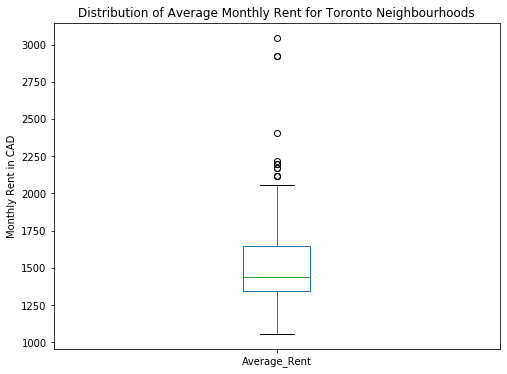

In [137]:
df_rental_prices_withPC['Average_Rent'].plot(kind='box', figsize=(8, 6))

plt.title('Distribution of Average Monthly Rent for Toronto Neighbourhoods')
plt.ylabel('Monthly Rent in CAD')

plt.show()

In [138]:
temp = df_rental_prices_withPC.groupby(by=['Postal Code'])['Average_Rent'].mean()
df_rental_prices_withPC1 = temp.to_frame(name = 'Average_rent').reset_index()
df_rental_prices_withPC1.shape

(90, 2)

In [139]:
df_rental_prices_withPC1.rename({'Average_rent':'AverageRent'},inplace=True)

In [140]:
df_rental_prices_withPC = pd.merge(df_rental_prices_withPC, df_rental_prices_withPC1, on='Postal Code', how='left')
df_rental_prices_withPC

,Postal Code,Neighborhood,Average_Rent,Average_rent
0,M1S,Agincourt,1397,1472.500000
1,L1S,Ajax,1237,1237.000000
2,M8W,Alderwood,1357,1283.000000
3,M5T,Annex,2198,2004.000000
4,M6K,Aurora,1371,1509.428571
...,...,...,...,...
163,M5B,Yonge,2035,2046.500000
164,M5B,Yonge-St Clair,2058,2046.500000
165,M4W,Yonge Corridor,2118,2118.000000
166,M2P,York Mills,1432,1432.000000


In [141]:
df_rental_prices_withPC = df_rental_prices_withPC[['Postal Code','Average_rent','Neighborhood']]
df_rental_prices_withPC.head()

,Postal Code,Average_rent,Neighborhood
0,M1S,1472.500000,Agincourt
1,L1S,1237.000000,Ajax
2,M8W,1283.000000,Alderwood
3,M5T,2004.000000,Annex
4,M6K,1509.428571,Aurora


In [142]:
df_rental_prices_withPC = df_rental_prices_withPC.groupby(by=['Postal Code','Average_rent']).agg(lambda x: ','.join(x))
df_rental_prices_withPC.reset_index(level=['Postal Code','Average_rent'], inplace=True)
df_rental_prices_withPC.shape

(90, 3)

In [143]:
### This is the consolidated dataset of average monthly rental prices for 2 bedroom properties in Toronto, with their associated postal codes
df_rental_prices_withPC.head()

,Postal Code,Average_rent,Neighborhood
0,L1S,1237.0,Ajax
1,L1V,1237.0,Pickering
2,L3Z,1313.0,"Bradford,East Gwillimbury,West Gwillimbury"
3,L4E,1439.0,Richmond Hill
4,L4J,1540.0,Westminster


In [145]:
df_rental_prices_withPC['Average_rent'].describe()

count      90.000000
mean     1573.346984
std       356.242685
min      1213.000000
25%      1359.250000
50%      1460.750000
75%      1612.250000
max      3047.000000
Name: Average_rent, dtype: float64

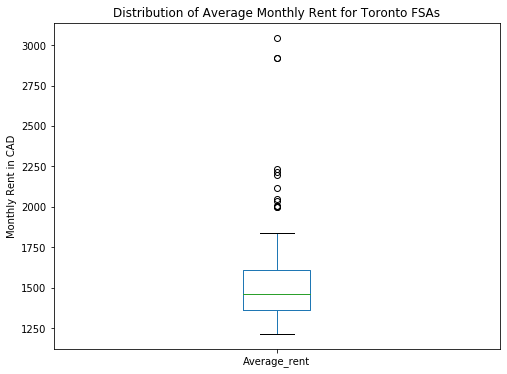

In [146]:
df_rental_prices_withPC['Average_rent'].plot(kind='box', figsize=(8, 6))

plt.title('Distribution of Average Monthly Rent for Toronto FSAs')
plt.ylabel('Monthly Rent in CAD')

plt.show()

In [204]:
df_master = pd.merge(df_properties_with_PC, df_rental_prices_withPC, on='Postal Code', how='left')
df_master.head()

,PropertyID,PropertyName,address,crossStreet,PropertyLat,PropertyLng,DistanceFromOffice,Postal Code,Borough,Neighborhood_x,Neigh_Latitude,Neigh_Longitude,Average_rent,Neighborhood_y
0,50e750c1e4b0cacd9c1d39a2,The Crossways,2340-2360 Dundas St W,at Bloor St W,43.657182,-79.452470,793,M6P,West Toronto,"High Park,The Junction South",43.661608,-79.464763,2005.000000,"High Park North,Junction"
1,554a46e6498e69d0f298ff89,High Park Village,111 Pacific Avenue,NaN,43.656437,-79.464438,1611,M6P,West Toronto,"High Park,The Junction South",43.661608,-79.464763,2005.000000,"High Park North,Junction"
2,4ae9fb0df964a5202db821e3,Little Italy,NaN,NaN,43.656374,-79.413223,2775,M6J,West Toronto,"Little Portugal,Trinity",43.647927,-79.419750,NaN,NaN
3,4d9d01a0a695721e235b080d,Bridge Condos,38 Joe Shuster Way,King St W & Dufferin St,43.641018,-79.424441,3011,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191,1509.428571,"Aurora,Church,Jamestown,King West,Mount Olive,..."
4,4afa3d22f964a520761722e3,Battery Park Tower,50 Lynn Williams St,btwn Western Battery and Pirandello,43.639024,-79.415510,3642,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191,1509.428571,"Aurora,Church,Jamestown,King West,Mount Olive,..."


In [205]:
df_master = df_master[df_master['Average_rent'].notnull()]

In [206]:
df_master = df_master[['Postal Code', 'PropertyID','DistanceFromOffice','Neigh_Latitude','Neigh_Longitude','Average_rent']]

In [207]:
temp1 = df_master.groupby(['Postal Code'])['PropertyID'].count()
temp2 = df_master.groupby(['Postal Code'])['DistanceFromOffice'].mean()
temp3 = temp1.to_frame(name = 'Number of Properties').reset_index()
temp4 = temp2.to_frame(name = 'DistanceFromOffice').reset_index()
temp5 = pd.merge(temp3, temp4, on='Postal Code', how='inner')
temp5.reset_index(drop=True,inplace = True)

temp5.head()

,Postal Code,Number of Properties,DistanceFromOffice
0,M4P,1,6163.000000
1,M4S,2,6245.000000
2,M4W,3,4751.000000
3,M4Y,13,5272.076923
4,M5A,2,6265.500000


In [208]:
df_master = pd.merge(df_master, temp5, on='Postal Code', how='inner')
df_master.reset_index(drop=True,inplace = True)
df_master.head()

,Postal Code,PropertyID,DistanceFromOffice_x,Neigh_Latitude,Neigh_Longitude,Average_rent,Number of Properties,DistanceFromOffice_y
0,M6P,50e750c1e4b0cacd9c1d39a2,793,43.661608,-79.464763,2005.000000,2,1202.000000
1,M6P,554a46e6498e69d0f298ff89,1611,43.661608,-79.464763,2005.000000,2,1202.000000
2,M6K,4d9d01a0a695721e235b080d,3011,43.636847,-79.428191,1509.428571,9,3754.444444
3,M6K,4afa3d22f964a520761722e3,3642,43.636847,-79.428191,1509.428571,9,3754.444444
4,M6K,54036a6a498e0e488d9b5e85,3423,43.636847,-79.428191,1509.428571,9,3754.444444


In [209]:
df_master = df_master[['Postal Code', 'Neigh_Latitude','Neigh_Longitude','Number of Properties','Average_rent','DistanceFromOffice_y']]
df_master.head()

,Postal Code,Neigh_Latitude,Neigh_Longitude,Number of Properties,Average_rent,DistanceFromOffice_y
0,M6P,43.661608,-79.464763,2,2005.000000,1202.000000
1,M6P,43.661608,-79.464763,2,2005.000000,1202.000000
2,M6K,43.636847,-79.428191,9,1509.428571,3754.444444
3,M6K,43.636847,-79.428191,9,1509.428571,3754.444444
4,M6K,43.636847,-79.428191,9,1509.428571,3754.444444


In [210]:
df_master = df_master.drop_duplicates()
df_master.reset_index(drop=True,inplace = True)
df_master.shape

(21, 6)

In [211]:
df_master.head()

,Postal Code,Neigh_Latitude,Neigh_Longitude,Number of Properties,Average_rent,DistanceFromOffice_y
0,M6P,43.661608,-79.464763,2,2005.000000,1202.000000
1,M6K,43.636847,-79.428191,9,1509.428571,3754.444444
2,M5T,43.653206,-79.400049,2,2004.000000,3837.500000
3,M5V,43.636039,-79.397400,28,2920.000000,4749.392857
4,M4W,43.679563,-79.377529,3,2118.000000,4751.000000


In [212]:
df_master

,Postal Code,Neigh_Latitude,Neigh_Longitude,Number of Properties,Average_rent,DistanceFromOffice_y
0,M6P,43.661608,-79.464763,2,2005.000000,1202.000000
1,M6K,43.636847,-79.428191,9,1509.428571,3754.444444
2,M5T,43.653206,-79.400049,2,2004.000000,3837.500000
3,M5V,43.636039,-79.397400,28,2920.000000,4749.392857
4,M4W,43.679563,-79.377529,3,2118.000000,4751.000000
5,M5S,43.662696,-79.400049,4,3047.000000,4782.000000
6,M4Y,43.665860,-79.383160,13,1664.000000,5272.076923
7,M5G,43.657952,-79.387383,2,2198.000000,4946.500000
8,M5B,43.657162,-79.378937,2,2046.500000,5413.000000
9,M5J,43.640816,-79.381752,5,2920.000000,5824.800000


In [213]:
from sklearn.preprocessing import StandardScaler

X = df_master[['Average_rent','DistanceFromOffice_y']]
X = np.nan_to_num(X)
standardized_attributes = StandardScaler().fit_transform(X)

In [214]:
X

array([[2005.        , 1202.        ],
       [1509.42857143, 3754.44444444],
       [2004.        , 3837.5       ],
       [2920.        , 4749.39285714],
       [2118.        , 4751.        ],
       [3047.        , 4782.        ],
       [1664.        , 5272.07692308],
       [2198.        , 4946.5       ],
       [2046.5       , 5413.        ],
       [2920.        , 5824.8       ],
       [1439.        , 6030.66666667],
       [2035.        , 6245.        ],
       [1838.        , 6265.5       ],
       [1647.5       , 2560.        ],
       [1809.5       , 3644.        ],
       [1213.        , 3992.        ],
       [1305.66666667, 4151.        ],
       [2218.        , 4258.        ],
       [1426.        , 4525.        ],
       [1391.66666667, 5483.        ],
       [2001.        , 6163.        ]])

In [215]:
standardized_attributes

array([[ 0.12577829, -2.79661981],
       [-0.84473975, -0.7320705 ],
       [ 0.12381991, -0.66489086],
       [ 1.91769759,  0.07269533],
       [ 0.34707543,  0.07399527],
       [ 2.16641207,  0.09906968],
       [-0.54202989,  0.49546928],
       [ 0.50374597,  0.2321258 ],
       [ 0.20705113,  0.60945517],
       [ 1.91769759,  0.94254034],
       [-0.98266578,  1.10905597],
       [ 0.18452974,  1.28241988],
       [-0.20127146,  1.29900134],
       [-0.57434319, -1.69819905],
       [-0.25708534, -0.82140368],
       [-1.42526006, -0.53992325],
       [-1.24378335, -0.41131582],
       [ 0.5429136 , -0.32476867],
       [-1.00812475, -0.10880524],
       [-1.07536252,  0.6660748 ],
       [ 0.11794476,  1.21609403]])

In [216]:
#Calculate location's composite square based upon average monthly rent and distance from office.
#Since both of these attributes are inversely related to the attarctiveness of a rental location/ property, a lower score will denote a more attractive location
# The weights assigned to average monthly rent and distance from office towards calculating a composite score are in the ratio 80:20
standardized_attributes[:,0] = 4 * standardized_attributes[:,0]

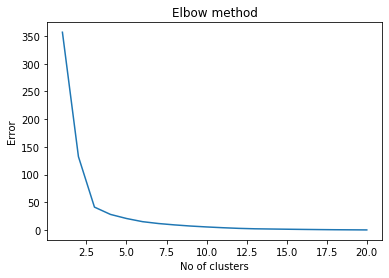

In [217]:
# We will now try to understand the similarities of these postal codes with one another by running a two-feature clustering algorithm based on the average rent and average distance from work location
#Let's try to find the optimum value of k for k-means clustering algorithm
Error =[]
for i in range(1, len(standardized_attributes)):
    kmeans = KMeans(n_clusters = i,n_init = 20).fit(standardized_attributes)
    kmeans.fit(standardized_attributes)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, len(standardized_attributes)), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [218]:
#We can observe from the previous chart that there is a sharp elbow point at k=3. We will set up 3 clusters going forward
num_clusters = 3
kmeans = KMeans(init = "k-means++",n_clusters=num_clusters, n_init = 20).fit(standardized_attributes)
labels = kmeans.labels_

In [219]:
# add clustering labels
df_master.insert(6, 'Cluster Labels', kmeans.labels_)
df_master.dropna(axis=0,inplace=True)

In [220]:
df_master.iloc[:,[0,4,5,6]]

,Postal Code,Average_rent,DistanceFromOffice_y,Cluster Labels
0,M6P,2005.000000,1202.000000,0
1,M6K,1509.428571,3754.444444,1
2,M5T,2004.000000,3837.500000,0
3,M5V,2920.000000,4749.392857,2
4,M4W,2118.000000,4751.000000,0
5,M5S,3047.000000,4782.000000,2
6,M4Y,1664.000000,5272.076923,1
7,M5G,2198.000000,4946.500000,0
8,M5B,2046.500000,5413.000000,0
9,M5J,2920.000000,5824.800000,2


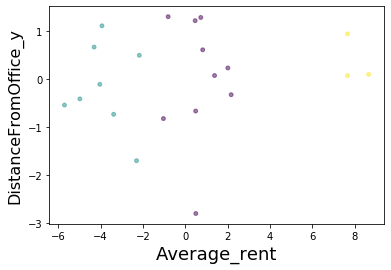

In [221]:
area = 15  
plt.scatter(standardized_attributes[:, 0], standardized_attributes[:, 1], s=area, c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Average_rent', fontsize=18)
plt.ylabel('DistanceFromOffice_y', fontsize=16)

plt.show()


In [222]:
#Analyzing clusters and assigning an easy-to-understand labels
## Note that cluster label values can change on each running of the kMeans alogorithm and the following assignments may have to be suitably revisited

label_desc = ['Mid-priced Experience in Popular Neighbourhoods', 'Economical but at a distance', 'Downtown Experience at a Steep Price']

In [223]:
import math
# create map

# Toronto latitude and longitude values
latitude = Office_lat
longitude = Office_lng
# create map of Toronto using latitude and longitude values
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
#Add radius circle
folium.Circle(
        [Office_lat, Office_lng], 
        radius = 12000,
        color='red', fill=True, weight = 1, fill_color = '#e02b0b', fill_opacity =0.05).add_to(map_clusters)
#Add office location
folium.CircleMarker(
        [Office_lat, Office_lng],
        radius=7,
        popup='Office Location',
        color='yellow',
        fill=True,
        fill_color='#e02b0b',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)

for lat, lon, poi, cluster, size in zip(df_master['Neigh_Latitude'], df_master['Neigh_Longitude'], df_master['Postal Code'],df_master['Cluster Labels'],df_master['Number of Properties']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' ' + label_desc[cluster], parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3*math.ceil(size ** (1/2)),
        popup=label,
        weight=1,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)



map_clusters